In [98]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("BDPAL").getOrCreate()
df = spark.read.csv("./data/student_data.csv", header=True, inferSchema=True)
df.show()

+------------------+----------------+---+--------------------+---+----+---------------+
|              Name|Class_or_Program|Age|             Country| IQ|CGPA|          Skill|
+------------------+----------------+---+--------------------+---+----+---------------+
|    Catherine Owen|            Arts| 21|               Tonga|105|3.18|  Communication|
|    Melissa Wright|            10th| 24|United Arab Emirates|102|2.72|     Leadership|
|        Laura Shaw|            12th| 18|Slovakia (Slovak ...|136| 3.4|  Communication|
|   Rodney Cummings|            10th| 17|            Barbados| 83|2.49|Problem-solving|
|     Barbara Hicks|            12th| 25|              Canada|129|2.39|  Communication|
|      Gerald Young|            Arts| 17|              Tuvalu|108|2.41|  Communication|
|      Andrea Hayes|            11th| 19|              France| 92|3.56|     Leadership|
|      Darrell Page|         Science| 23|                Togo|123|2.98|  Communication|
|      John Jenkins|            

In [99]:
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Class_or_Program: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- IQ: integer (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- Skill: string (nullable = true)



In [100]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+----------------+---+-------+---+----+-----+
|Name|Class_or_Program|Age|Country| IQ|CGPA|Skill|
+----+----------------+---+-------+---+----+-----+
|   0|               0|  0|      0|  0|   0|    0|
+----+----------------+---+-------+---+----+-----+



In [101]:
df.groupBy("Class_or_Program").count().show()

+----------------+-----+
|Class_or_Program|count|
+----------------+-----+
|            10th| 8502|
|         Science| 8300|
|        Commerce| 8240|
|            11th| 8355|
|            Arts| 8201|
|            12th| 8402|
+----------------+-----+



In [104]:
print(df.count())
print(df.distinct().count())

50000
50000


In [105]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

countryIndexer = StringIndexer(inputCol="Country", outputCol="CountryIndex")
classIndexer = StringIndexer(inputCol="Class_or_Program", outputCol="ClassIndex")
SkillIndexer = StringIndexer(inputCol="Skill", outputCol="SkillIndex")

pipeline = Pipeline(stages=[countryIndexer, classIndexer, SkillIndexer])
df = pipeline.fit(df).transform(df)
df.show()

+------------------+----------------+---+--------------------+---+----+---------------+------------+----------+----------+
|              Name|Class_or_Program|Age|             Country| IQ|CGPA|          Skill|CountryIndex|ClassIndex|SkillIndex|
+------------------+----------------+---+--------------------+---+----+---------------+------------+----------+----------+
|    Catherine Owen|            Arts| 21|               Tonga|105|3.18|  Communication|       184.0|       5.0|       0.0|
|    Melissa Wright|            10th| 24|United Arab Emirates|102|2.72|     Leadership|        46.0|       0.0|       1.0|
|        Laura Shaw|            12th| 18|Slovakia (Slovak ...|136| 3.4|  Communication|       153.0|       1.0|       0.0|
|   Rodney Cummings|            10th| 17|            Barbados| 83|2.49|Problem-solving|        60.0|       0.0|       2.0|
|     Barbara Hicks|            12th| 25|              Canada|129|2.39|  Communication|       121.0|       1.0|       0.0|
|      Gerald Yo

In [106]:
df.select("Skill", "SkillIndex").distinct().orderBy("SkillIndex").show()

+---------------+----------+
|          Skill|SkillIndex|
+---------------+----------+
|  Communication|       0.0|
|     Leadership|       1.0|
|Problem-solving|       2.0|
|     Creativity|       3.0|
+---------------+----------+



In [107]:
df.groupBy("Skill").count().show()

+---------------+-----+
|          Skill|count|
+---------------+-----+
|Problem-solving|12499|
|     Creativity|12374|
|     Leadership|12537|
|  Communication|12590|
+---------------+-----+



In [108]:
feature_columns = ["CountryIndex", "ClassIndex", "IQ", "CGPA", "Age"]
target_column = "SkillIndex"

In [109]:
for col in feature_columns:
    print("Correlation between Skill and {} = {}".format(col, df.stat.corr(target_column, col)))

Correlation between Skill and CountryIndex = -0.008673814204687382
Correlation between Skill and ClassIndex = 0.004493756084668397
Correlation between Skill and IQ = 0.0020113617929390336
Correlation between Skill and CGPA = -0.00223698324708866
Correlation between Skill and Age = -0.0018222632618601511


In [110]:
from pyspark.ml.feature import VectorAssembler

df_selected = df.select(*feature_columns, target_column)
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

df_transformed = assembler.transform(df_selected)
df_final = df_transformed.select("features", target_column)

In [111]:
train_data, test_data = df_final.randomSplit([0.7, 0.3])

In [113]:
train_data.show(5)

+--------------------+----------+
|            features|SkillIndex|
+--------------------+----------+
|[0.0,0.0,84.0,2.2...|       3.0|
|[0.0,0.0,86.0,3.2...|       3.0|
|[0.0,0.0,88.0,2.5...|       0.0|
|[0.0,0.0,88.0,2.5...|       0.0|
|[0.0,0.0,89.0,3.5...|       3.0|
+--------------------+----------+
only showing top 5 rows



In [114]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="SkillIndex", predictionCol="prediction", metricName="accuracy")
results = []

In [115]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="SkillIndex", featuresCol="features", maxDepth=5, impurity="gini", maxBins=250)
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
results.append(["Decision Tree", accuracy])
print(f"Accuracy: {accuracy}")

Accuracy: 0.25136867405528107


In [116]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="SkillIndex", featuresCol="features", numTrees=100, maxBins=250)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

accuracy = evaluator.evaluate(rf_predictions, {evaluator.metricName: "accuracy"})
results.append(["Random Forest", accuracy])
print(f"Accuracy: {accuracy}")


24/01/07 13:56:36 WARN DAGScheduler: Broadcasting large task binary with size 1093.4 KiB


Accuracy: 0.25150220323140604


In [117]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="SkillIndex", featuresCol="features", maxIter=10)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

accuracy = evaluator.evaluate(lr_predictions, {evaluator.metricName: "accuracy"})
results.append(["Logistic Regression", accuracy])
print(f"Accuracy: {accuracy}")

Accuracy: 0.25143543864334356


In [118]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(labelCol="SkillIndex", featuresCol="features")
nb_model = nb.fit(train_data)
nb_predictions = nb_model.transform(test_data)

accuracy = evaluator.evaluate(nb_predictions, {evaluator.metricName: "accuracy"})
results.append(["Naive Bayes", accuracy])
print(f"Accuracy: {accuracy}")

Accuracy: 0.25423955134196824


In [119]:
results_df = spark.createDataFrame(results, ["Model", "Accuracy"])
results_df.orderBy("Accuracy", ascending=False).show()

+-------------------+-------------------+
|              Model|           Accuracy|
+-------------------+-------------------+
|        Naive Bayes|0.25423955134196824|
|      Random Forest|0.25150220323140604|
|Logistic Regression|0.25143543864334356|
|      Decision Tree|0.25136867405528107|
+-------------------+-------------------+



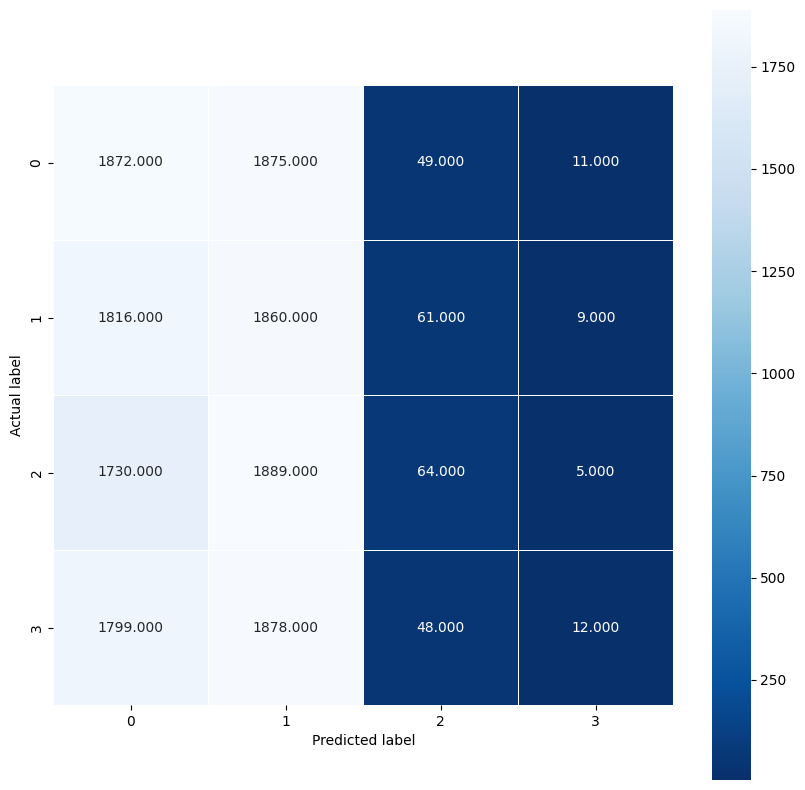

In [120]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true = test_data.select("SkillIndex").toPandas()
y_pred = nb_predictions.select("prediction").toPandas()
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap="Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.show()


In [132]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
             .build())

cv = CrossValidator(estimator=nb, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cv_model = cv.fit(train_data)
best_model = cv_model.bestModel
print(f"Best smoothing: ", best_model._java_obj.getSmoothing())


Best smoothing:  0.0


In [134]:
accuracy_before = results_df.filter(results_df.Model == "Naive Bayes").select('Accuracy').first()[0]
print(f"Accuracy before tuning: {accuracy_before}")

cv_predictions = best_model.transform(test_data)
accuracy_after = evaluator.evaluate(cv_predictions)
print(f"Accuracy after tuning: {accuracy_after}")

diff = accuracy_after - accuracy_before
print(f"Accuracy improvement: {diff}")

Accuracy before tuning: 0.25423955134196824
Accuracy after tuning: 0.25423955134196824
Accuracy improvement: 0.0
